In [1]:
import numpy as np
from models.models import JetTaggingModule
from data.data_handling import JetTaggingDataModule

### Load the trained Model

In [2]:
checkpoint = "toptagging_checkpoints/version_3/checkpoints/epoch=19-step=31260.ckpt" # iaformer
model = JetTaggingModule.load_from_checkpoint(checkpoint)
model = model.model.eval()

Head dim is 16



### Load the dataset

In [ ]:
data_path = "/mnt/d/waleed/CP-Higgs/GraphTransformer/GraphTransformer/QG/"
file_list = ["train_graphs.h5", "val_graphs.h5", "test_graphs.h5"]
batch_size = 32
dataset = JetTaggingDataModule(data_dir=data_path, file_list=file_list, batch_size=batch_size)
dataset.setup(stage="test")
dataloader = dataset.test_dataloader()

In [4]:
limit = 32
n_layers = 12
n_heads = 16
n_particles = 100
batch_size = dataloader.batch_size  # make sure this is defined
n_events = limit * batch_size

attn_matrix = np.zeros((n_events, n_layers, n_heads, n_particles, n_particles))
cka_matrix = np.zeros((n_events, n_layers, n_particles))
targets = np.zeros((n_events,))

for j, batch in enumerate(dataloader):
    if j == limit:
        break
    x, u, y = batch["node_features"].cuda(), batch["edge_features"].cuda(), batch["labels"].cuda()
    _, attn_weights, activations = model(x, u)

    start = j * batch_size
    end = start + attn_weights.size(0)  # just in case last batch is smaller
    attn_matrix[start:end] = attn_weights.detach().cpu().numpy()
    cka_matrix[start:end] = activations.detach().cpu().numpy()
    targets[start:end] = y.detach().cpu().numpy()

In [5]:
# save the arrays
np.save("cka_matrix.npy", cka_matrix)
np.save("attn_matrix.npy", attn_matrix[:10])
np.save("targets.npy", targets[:10])

## Ploting
### 1. Attention Maps

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

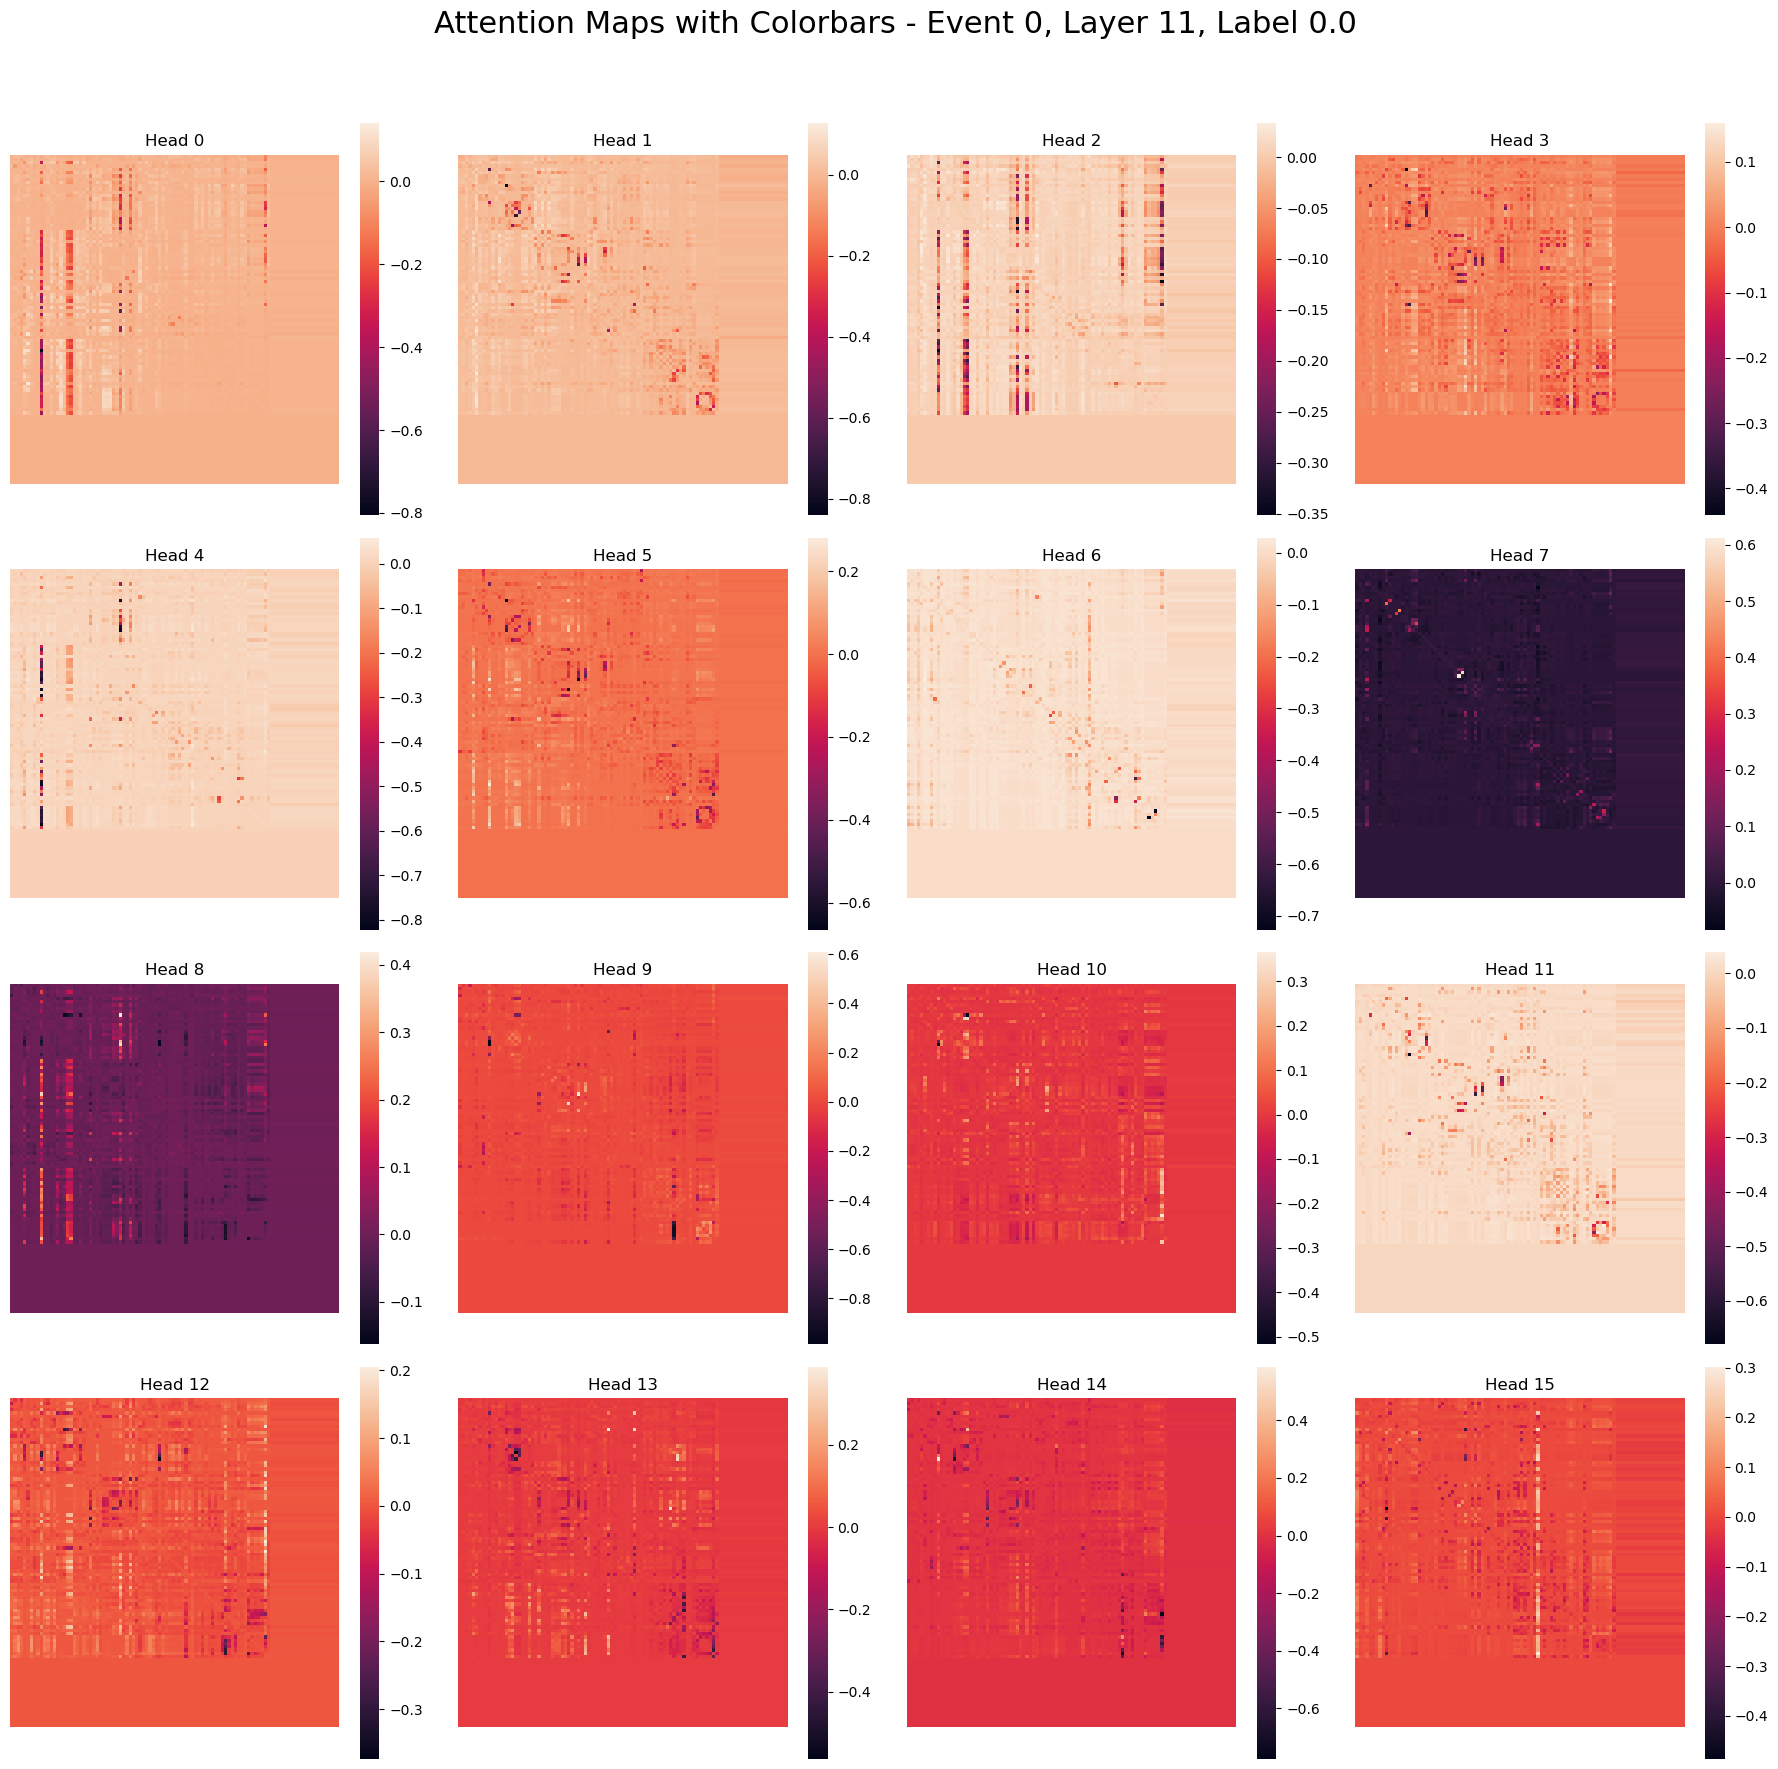

In [6]:
# Choose event index (e.g., 0) and last layer index (11)
event_idx = 0
layer_idx = 11

# Extract the attention maps for all 16 heads
maps = attn_matrix[event_idx, layer_idx]  # shape: (16, 100, 100)

# Set up a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(18, 18))
fig.suptitle(f'Attention Maps with Colorbars - Event {event_idx}, Layer {layer_idx}, Label {targets[event_idx]}', fontsize=22)

for i in range(16):
    ax = axes[i // 4, i % 4]
    sns.heatmap(maps[i], ax=ax, cbar=True, square=True, xticklabels=False, yticklabels=False)
    ax.set_title(f'Head {i}', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2. CKA Similarity Matrix

In [7]:
from callbacks.cka import CKA

Text(0.5, 1.0, 'CKA Similarity Matrix')

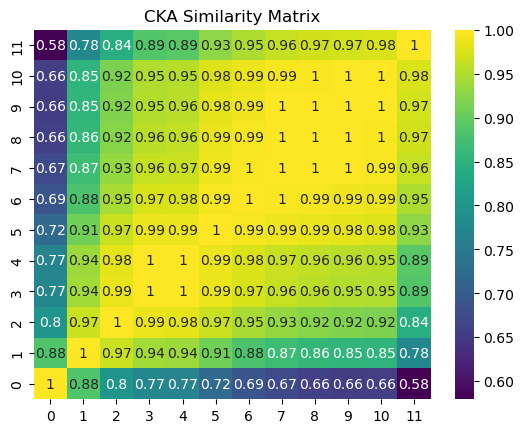

In [ ]:
# Calculate CKA Similarity 
cka = CKA()

cka_similarity_matrix = np.zeros((n_layers, n_layers))

for i in range(n_layers):
    for j in range(n_layers):
        X = cka_matrix[:, i]
        Y = cka_matrix[:, j]
        cka_similarity_matrix[i, j] = cka.linear_CKA(X, Y)

_ = plt.figure()
sns.heatmap(cka_similarity_matrix, annot=True, cmap="viridis")
plt.gca().invert_yaxis()
plt.title("CKA Similarity Matrix")

Text(0.5, 1.0, 'CKA Similarity Matrix')

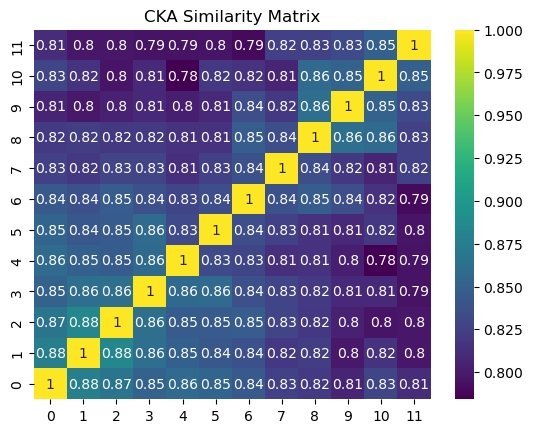

In [ ]:
# Calculate CKA Similarity (average over particles)
cka = CKA()


cka_similarity_matrix_avg = np.zeros((n_layers, n_layers))
cka_matrix_avg = cka_matrix.mean(axis=1)

for i in range(n_layers):
    for j in range(n_layers):
        X = cka_matrix_avg[:, i:i+1]
        Y = cka_matrix_avg[:, j:j+1]
        cka_similarity_matrix_avg[i, j] = cka.linear_CKA(X, Y)

_ = plt.figure()
sns.heatmap(cka_similarity_matrix_avg, annot=True, cmap="viridis")
plt.gca().invert_yaxis()
plt.title("CKA Similarity Matrix")